***Import Libraries***

In [4]:
import warnings
import gc
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torchaudio

from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from matplotlib import  pyplot as plt
from pypesq import pesq

%matplotlib inline

warnings.filterwarnings(action='ignore', category=DeprecationWarning)


***Set noise class to train model***

In [5]:
noise_class=3

In [6]:
TRAIN_INPUT_DIR = Path('Datasets/US_Class'+str(noise_class)+'_Train_Input')
TRAIN_TARGET_DIR = Path('Datasets/US_Class'+str(noise_class)+'_Train_Output')
TEST_NOISY_DIR = Path('Datasets/US_Class'+str(noise_class)+'_Test_Input')
TEST_CLEAN_DIR = Path('Datasets/clean_testset_wav')

In [7]:
np.random.seed(999)
torch.manual_seed(999)

train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')
       
DEVICE = torch.device('cuda' if train_on_gpu else 'cpu')

No GPU available, training on CPU.


In [8]:
SAMPLE_RATE = 48000
N_FFT = (SAMPLE_RATE * 64) // 1000 
HOP_LENGTH = (SAMPLE_RATE * 16) // 1000 

***Define SpeechDataSet Class***

In [9]:
class SpeechDataset(Dataset):
    
    def __init__(self, noisy_files, target_files, n_fft=64, hop_length=16):
        super().__init__()
        
        self.noisy_files = sorted(noisy_files)
        self.target_files = sorted(target_files)
        
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.len_ = len(self.noisy_files)
        
        self.max_len = 165000
     
    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        waveform, _ = torchaudio.load(file)
        # print(_)
        return waveform
  
    def __getitem__(self, index):

        file_t=self.target_files[index]
        file_n=self.noisy_files[index]
        file_t=str(file_t)
        file_n=str(file_n)
        x_target = self.load_sample(file_t)
        x_noisy = self.load_sample(file_n)
        
        x_target = self._prepare_sample(x_target)
        x_noisy = self._prepare_sample(x_noisy)
        
        x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft, hop_length=self.hop_length,window=torch.ones(N_FFT, device=DEVICE), normalized=True,return_complex=True)
        x_target_stft = torch.stft(input=x_target, n_fft=self.n_fft, hop_length=self.hop_length,window=torch.ones(N_FFT, device=DEVICE), normalized=True,return_complex=True)
        # return 0
        # print(x_noisy_stft)
        return torch.view_as_real(x_noisy_stft), torch.view_as_real(x_target_stft)
        
    def _prepare_sample(self, waveform):
        waveform = waveform.numpy()
        # print(waveform.shape)
        current_len = waveform.shape[1]
        # print(current_len)
        output = np.zeros((1, self.max_len), dtype='float32')
        # print(output.shape)
        output[0, -current_len:] = waveform[0,:self.max_len]
        output = torch.from_numpy(output)
        # print(output.shape)
        return output

In [10]:
train_input_files = sorted(list(TRAIN_INPUT_DIR.rglob('*.wav')))
train_target_files = sorted(list(TRAIN_TARGET_DIR.rglob('*.wav')))

test_noisy_files = sorted(list(TEST_NOISY_DIR.rglob('*.wav')))
test_clean_files = sorted(list(TEST_CLEAN_DIR.rglob('*.wav')))

# print("No. of Training files:",len(train_input_files))
# print("No. of Testing files:",len(test_noisy_files))

***Make SpeechDataSet Objects for test and train files***

In [11]:
test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)
train_dataset = SpeechDataset(train_input_files, train_target_files, N_FFT, HOP_LENGTH)

In [12]:
import matplotlib.pyplot as plt
import librosa

In [13]:
spectrogram = torchaudio.transforms.Spectrogram(
    n_fft=N_FFT,
    win_length=16,
    hop_length=HOP_LENGTH,
    center=True,
    pad_mode="reflect",
    power=2.0,
)

In [14]:
def plot_spectrogram(spec, title=None, ylabel="freq_bin", aspect="auto", xmax=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Spectrogram (db)")
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(spec), origin="lower", aspect=aspect)
    if xmax:
        axs.set_xlim((0, xmax))
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


In [15]:
spec=spectrogram(train_dataset.load_sample("Datasets/US_Class3_Test_Input/p232_001.wav"))


In [16]:
# plot_spectrogram(spec[1], title="torchaudio")

***Make Dataloader for train and test dataset***

In [17]:
test_loader=DataLoader(test_dataset,batch_size=1,shuffle=True)
train_loader=DataLoader(train_dataset,batch_size=1,shuffle=True)

***Define Convolution Class for Complex number For Down Sampling***

In [18]:
class CConv2d(nn.Module):

    def __init__(self,in_channels,out_channels,kernel_size,stride=1,padding=0):
        super().__init__()

        self.in_channels=in_channels
        self.out_channels=out_channels
        self.kernel_size=kernel_size
        self.padding=padding
        self.stride=stride
        self.real_conv= nn.Conv2d(in_channels=self.in_channels,
                                  out_channels=self.out_channels,
                                  kernel_size=self.kernel_size,
                                  padding=self.padding,
                                  stride=self.stride)
        self.imag_conv = nn.Conv2d(in_channels=self.in_channels,
                                  out_channels=self.out_channels,
                                  kernel_size=self.kernel_size,
                                  padding=self.padding,
                                  stride=self.stride)
        
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.imag_conv.weight)
    def forward(self,x):
        # print(x.shape)
        x_real = x[...,0]
        x_imag= x[...,1]
        c_real = self.real_conv(x_real)-self.imag_conv(x_imag)
        c_imag=self.imag_conv(x_real)+self.real_conv(x_imag)

        output = torch.stack([c_real,c_imag],dim=-1)
        return output


***Define Convolution Class for Complex number For Up Sampling***

In [19]:
class CConvTranspose2d(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,out_padding=0,padding=0):
        super().__init__()
        self.in_channels=in_channels
        self.out_channels=out_channels
        self.kernel_size=kernel_size
        self.padding=padding
        self.out_padding=out_padding
        self.stride=stride
        
        self.real_convt= nn.ConvTranspose2d(in_channels=self.in_channels,
                                            out_channels=self.out_channels,
                                            kernel_size=self.kernel_size,
                                            stride=self.stride,
                                            output_padding=self.out_padding,
                                            padding=self.padding)
        self.imag_convt=nn.ConvTranspose2d(in_channels=self.in_channels,
                                            out_channels=self.out_channels,
                                            kernel_size=self.kernel_size,
                                            stride=self.stride,
                                            output_padding=self.out_padding,
                                            padding=self.padding)
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.imag_convt.weight)


    def forward(self,x):
        # print(x.shape)
        x_real=x[...,0]
        x_imag=x[...,1]

        c_real=self.real_convt(x_real)-self.imag_convt(x_imag)
        c_imag=self.imag_convt(x_real)+self.real_convt(x_imag)
            
        output=torch.stack([c_real,c_imag],dim=-1)
        
        return output

***Define Batch Normalisation Class***

In [20]:
class CBatchNorm2D(nn.Module):
    def __init__(self,num_features,eps=1e-05,momentum=0.1,affine=True, track_running_stats=True):
        super().__init__()
        self.num_features=num_features
        self.affine=affine
        self.momentum=momentum
        self.eps=eps
        self.track_running_stats=track_running_stats

        self.real_b=nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.imag_b=nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        
    def forward(self,x):
        real=x[...,0]
        imag=x[...,1]

        real_cb=self.real_b(real)
        imag_cb=self.imag_b(imag)

        output=torch.stack([real_cb,imag_cb],dim=-1)
        # print(x.shape)

        return output
    

***Encoder***

Convolution --> Complex Batch Normalisation ---> Activation Function

In [21]:
class Encoder(nn.Module):
    def __init__(self,in_channels=1,out_channels=45,stride=(2,2),kernel_size=(7,5),padding=(0,0)):
        super().__init__()
        self.kernel_size=kernel_size
        self.stride=stride
        self.padding=padding
        self.in_channels=in_channels
        self.out_channels=out_channels

        self.cconv= CConv2d(in_channels=self.in_channels,
                            out_channels=self.out_channels,
                            kernel_size=self.kernel_size,
                            stride=self.stride,
                            padding=self.padding)
        self.cbn=CBatchNorm2D(num_features=self.out_channels)

        self.leaky_relu=nn.LeakyReLU()
        
    def forward(self,x):
        conved=self.cconv(x)
        normed=self.cbn(conved)
        acted=self.leaky_relu(normed)
        # print(acted.shape)
        return acted


***Decoder***

Transposed Convolution --->  Complex Batch Normalisation --->  Activation Function 

In [22]:
class Decoder(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size,stride,padding,out_padding,last_layer):
        super().__init__()

        self.kernel_size = kernel_size
        self.stride_size = stride
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.out_padding = out_padding
        self.padding = padding
        
        self.last_layer = last_layer
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, 
                                       out_channels=self.out_channels, 
                             kernel_size=self.kernel_size,
                               stride=self.stride_size, 
                               out_padding=self.out_padding, 
                               padding=self.padding
                               )
        
        self.cbn = CBatchNorm2D(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output

***DCUNET Model Class***

- Define Parameters
- Creates Encoders For Down Sampling
- Creates Decoders For Up Sampling
- Apply Down Sampling and then UpSampling adn return istft Output

In [23]:
class DCUnet(nn.Module):
    """
    Deep Complex U-Net class of the model.
    """
    def __init__(self, n_fft=64, hop_length=16):
        super().__init__()
        
        # for istft
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.set_size(model_complexity=int(45//1.414), input_channels=1, model_depth=20)
        self.encoders = []
        self.model_length = 20 // 2
        
        for i in range(self.model_length):
            module = Encoder(in_channels=self.enc_channels[i], out_channels=self.enc_channels[i + 1],
                             kernel_size=self.enc_kernel_sizes[i], stride=self.enc_strides[i], padding=self.enc_paddings[i])
            self.add_module("encoder{}".format(i), module)
            self.encoders.append(module)

        self.decoders = []

        for i in range(self.model_length):
            if i != self.model_length - 1:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1], 
                                 kernel_size=self.dec_kernel_sizes[i], stride=self.dec_strides[i], padding=self.dec_paddings[i],
                                 out_padding=self.dec_output_padding[i],last_layer=False)
            else:
                module = Decoder(in_channels=self.dec_channels[i] + self.enc_channels[self.model_length - i], out_channels=self.dec_channels[i + 1], 
                                 kernel_size=self.dec_kernel_sizes[i], stride=self.dec_strides[i], padding=self.dec_paddings[i],
                                 out_padding=self.dec_output_padding[i], last_layer=True)
            self.add_module("decoder{}".format(i), module)
            self.decoders.append(module)
       
        
    def forward(self, x, is_istft=True):
        # print('x : ', x.shape)
        orig_x = x
        xs = []
        for i, encoder in enumerate(self.encoders):
            xs.append(x)
            x = encoder(x)
            # print('Encoder : ', x.shape)
            
        p = x
        # print(x.shape)
        for i, decoder in enumerate(self.decoders):
            p = decoder(p)
            if i == self.model_length - 1:
                break
            # print('Decoder : ', p.shape)
            p = torch.cat([p,xs[self.model_length - 1 - i]], dim=1)
        
        # u9 - the mask
        
        mask = p
        
        # print('mask : ', mask.shape)
        # print("Done")
        
        output = mask * orig_x
        output = torch.squeeze(output, 1)
        output=torch.view_as_complex(output)
        # print(output.shape)
        if is_istft:
            output = torch.istft(output, n_fft=self.n_fft, hop_length=self.hop_length,window=torch.ones(N_FFT, device=DEVICE),return_complex=False, normalized=True)
        
        return output

    
    def set_size(self, model_complexity, model_depth=20, input_channels=1):

        if model_depth == 20:
            self.enc_channels = [input_channels,
                                 model_complexity,
                                 model_complexity,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 128]

            self.enc_kernel_sizes = [(7, 1),
                                     (1, 7),
                                     (6, 4),
                                     (7, 5),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3),
                                     (5, 3)]

            self.enc_strides = [(1, 1),
                                (1, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1),
                                (2, 2),
                                (2, 1)]

            self.enc_paddings = [(3, 0),
                                 (0, 3),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0)]

            self.dec_channels = [0,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity * 2,
                                 model_complexity,
                                 model_complexity,
                                 1]

            self.dec_kernel_sizes = [(6, 3), 
                                     (6, 3),
                                     (6, 3),
                                     (6, 4),
                                     (6, 3),
                                     (6, 4),
                                     (8, 5),
                                     (7, 5),
                                     (1, 7),
                                     (7, 1)]

            self.dec_strides = [(2, 1), 
                                (2, 2), 
                                (2, 1), 
                                (2, 2), 
                                (2, 1), 
                                (2, 2), 
                                (2, 1), 
                                (2, 2), 
                                (1, 1),
                                (1, 1)]

            self.dec_paddings = [(0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 0),
                                 (0, 3),
                                 (3, 0)]
            
            self.dec_output_padding = [(0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0),
                                       (0,0)]
        else:
            raise ValueError("Unknown model depth : {}".format(model_depth))

In [24]:
import os
basepath = str(noise_class)+"NoiseToNoise"
os.makedirs(basepath,exist_ok=True)
os.makedirs(basepath+"/Weights",exist_ok=True)
os.makedirs(basepath+"/Samples",exist_ok=True)

***Loss Function***

In [25]:
def wsdr_fn(x_, y_pred_, y_true_, eps=1e-8):
   
    y_true_ = torch.squeeze(y_true_, 1)
    y_true = torch.istft(torch.view_as_complex(y_true_), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,window=torch.ones(N_FFT, device=DEVICE),return_complex=False)
    x_ = torch.squeeze(x_, 1)
    x = torch.istft(torch.view_as_complex(x_), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,window=torch.ones(N_FFT, device=DEVICE),return_complex=False)

    y_pred = y_pred_.flatten(1)
    y_true = y_true.flatten(1)
    x = x.flatten(1)


    def sdr_fn(true, pred, eps=1e-8):
        num = torch.sum(true * pred, dim=1)
        den = torch.norm(true, p=2, dim=1) * torch.norm(pred, p=2, dim=1)
        return -(num / (den + eps))


    z_true = x - y_true
    z_pred = x - y_pred

    a = torch.sum(y_true**2, dim=1) / (torch.sum(y_true**2, dim=1) + torch.sum(z_true**2, dim=1) + eps)
    wSDR = a * sdr_fn(y_true, y_pred) + (1 - a) * sdr_fn(z_true, z_pred)
    return torch.mean(wSDR)


***Train Epoch***

In [26]:
def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    try:
        for noisy_x, clean_x in train_loader:

            noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)

            net.zero_grad()

            pred_x = net(noisy_x)
            loss = loss_fn(noisy_x, pred_x, clean_x)
            loss.backward()
            optimizer.step()

            train_ep_loss += loss.item() 
            counter += 1
            # print(train_ep_loss)
            # if counter>=2:
            #     break

        train_ep_loss /= counter

        gc.collect()
        torch.cuda.empty_cache()
        return train_ep_loss
    except:
        train_ep_loss

***Test Epoch***

In [27]:
def test_epoch(net, test_loader, loss_fn):
    try:    
        net.eval()
        test_ep_loss = 0.
        counter = 0.
    
        for noisy_x, clean_x in test_loader:
        

            noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)
            pred_x = net(noisy_x)
       
            loss = loss_fn(noisy_x, pred_x, clean_x)

            test_ep_loss += loss.item() 
        
            counter += 1
            # print(test_ep_loss)

            #for checking the working of Model
            # if counter>=2:
            #     break
     
        test_ep_loss /= counter
    
    
        gc.collect()
        torch.cuda.empty_cache()
        
    
        return test_ep_loss
    except:
        test_ep_loss,{}
        

***Train***

In [28]:
def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs):
    train_losses = []
    test_losses = []
    try:
        
    # print("eme")
        for e in tqdm(range(epochs)):
        
        # print("sms")
            if e == 0:
                with torch.no_grad():
                    test_loss = test_epoch(net, test_loader, loss_fn)
                
                print("Loss before training:{:.6f}".format(test_loss))
            train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
            test_loss = 0
            scheduler.step()
        
            with torch.no_grad():
                test_loss = test_epoch(net, test_loader, loss_fn)

            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            torch.save(net.state_dict(), basepath +'/Weights/dc20_model_'+str(e+1)+'.pth')
            torch.save(optimizer.state_dict(), basepath+'/Weights/dc20_opt_'+str(e+1)+'.pth') 
        

            torch.cuda.empty_cache()
            gc.collect()
            print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Test Loss: {:.6f}".format(test_loss))
            
        return train_losses, test_losses
    except: 
        return train_losses, test_losses

***Create Model Object***

With Adam Optimiser

In [29]:
gc.collect()
torch.cuda.empty_cache()
dcunet20 = DCUnet(N_FFT, HOP_LENGTH).to(DEVICE)
optimizer = torch.optim.Adam(dcunet20.parameters())
loss_fn = wsdr_fn
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)


In [30]:
# specify paths and uncomment to resume training from a given point
# model_checkpoint = torch.load(path_to_model)
# opt_checkpoint = torch.load(path_to_opt)
# dcunet20.load_state_dict(model_checkpoint)
# optimizer.load_state_dict(opt_checkpoint)

***Train Model***

In [31]:
train_losses, test_losses = train(dcunet20, train_loader, test_loader, loss_fn, optimizer, scheduler, 5)

  0%|          | 0/5 [00:00<?, ?it/s]

Loss before training:-0.260089


***Plot Loss Vs Epoch***

[-0.5418997704982758, -0.5743750780820847, 0.07664692401885986, -0.708832710981369, 0.21578210592269897]


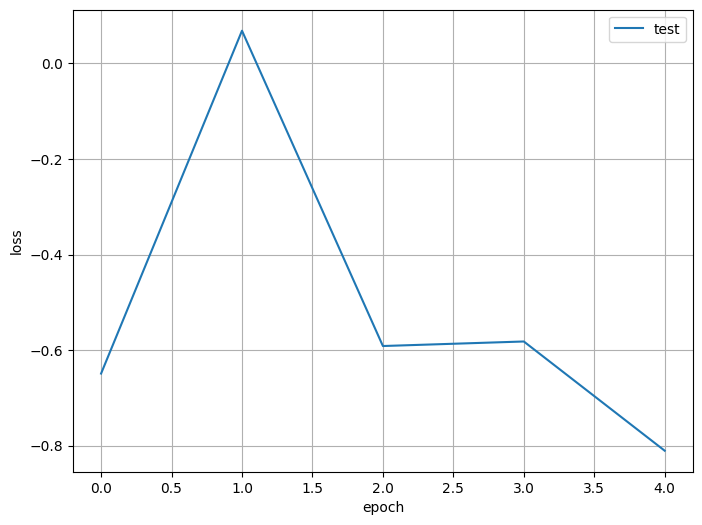

In [ ]:
# print(train_losses)
# f = plt.figure(figsize=(8, 6))
# plt.grid()
# plt.plot(test_losses, label='test')
# plt.xlabel('epoch')
# plt.ylabel('loss')
# plt.legend()
# plt.show()

***Metric***

In [ ]:
# def pesq_score(net, test_loader):
#     net.eval()
#     test_pesq = 0.
#     counter = 0.


#     for noisy_x, clean_x in test_loader:
        
#         noisy_x = noisy_x.to(DEVICE)
#         with torch.no_grad():
#             pred_x = net(noisy_x)
#         clean_x = torch.squeeze(clean_x, 1)
#         clean_x = torch.istft(torch.view_as_complex(clean_x), n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True,window=torch.ones(N_FFT, device=DEVICE),return_complex=False)
        
        
#         psq = 0.
#         for i in range(len(clean_x)):
#             clean_x_16 = torchaudio.transforms.Resample(48000, 16000)(clean_x[i,:].view(1,-1))
#             pred_x_16 = torchaudio.transforms.Resample(48000, 16000)(pred_x[i,:].view(1,-1))

#             clean_x_16 = clean_x_16.cpu().cpu().numpy()
#             pred_x_16 = pred_x_16.detach().cpu().numpy()
            
            
            
#             psq += pesq(clean_x_16.flatten(), pred_x_16.flatten(), 16000)
            
#         psq /= len(clean_x)
#         test_pesq += psq
#         counter += 1

#     test_pesq /= counter 
#     return test_pesq

***Signal Analysis For Clean, Predicted And Noisy***

In [ ]:
# index = 3

In [ ]:
# test_noisy_files = sorted(list(Path("Samples/Sample_Test_Input").rglob('*.wav')))
# test_clean_files = sorted(list(Path("Samples/Sample_Test_Target").rglob('*.wav')))

# test_dataset = SpeechDataset(test_noisy_files, test_clean_files, N_FFT, HOP_LENGTH)

# # For testing purpose
# test_loader_single_unshuffled = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# dcunet20.eval()
# test_loader_single_unshuffled_iter = iter(test_loader_single_unshuffled)

# x_n, x_c = next(test_loader_single_unshuffled_iter)
# for _ in range(index):
#     x_n, x_c = next(test_loader_single_unshuffled_iter)

# x_est = dcunet20(x_n, is_istft=True)

In [ ]:
# x_est_np = x_est[0].view(-1).detach().cpu().numpy()
# x_c_np = torch.istft(torch.view_as_complex(torch.squeeze(x_c[0], 1)), n_fft=N_FFT, hop_length=HOP_LENGTH,window=torch.ones(N_FFT, device=DEVICE),return_complex=False, normalized=True).view(-1).detach().cpu().numpy()
# x_n_np = torch.istft(torch.view_as_complex(torch.squeeze(x_n[0], 1)), n_fft=N_FFT, hop_length=HOP_LENGTH,window=torch.ones(N_FFT, device=DEVICE),return_complex=False, normalized=True).view(-1).detach().cpu().numpy()

***Noisy***

In [ ]:
# plt.plot(x_n_np)

***Predicted***

In [ ]:
# plt.plot(x_est_np)

***Clean***

In [ ]:
# plt.plot(x_c_np)
